[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobasserulHaque/Explainable-Techniques---Machine-Learning-Court/blob/main/Assignment3_Explainable_Techniques_ML_Court.ipynb)




### Assignment 3 : Explainable Techniques - Machine Learning Court

**Mobasserul Haque**

I had been assigned the following case scenario and role:

🩺 **Case 2: Cancer Misclassification** 🟥 **Prosecution**








## 🩺 Case 2: Tumor Misclassification – Breast Cancer Dataset
#### 🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

#### 🟥 Prosecution
Use explanation tools to evaluate how the model arrived at this decision. Consider whether any key medical indicators might have been overlooked or minimized.

#### 🟦 Defense
Defend the decision with reference to the model’s logic and learned feature importance. Consider how this decision aligns with the broader data trends.

In [1]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [2]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


**Default-threshold evaluation**

=== Report @ threshold 0.50 (positive = malignant) ===
              precision    recall  f1-score   support

malignant(0)       0.98      0.93      0.95        43
   benign(1)       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC AUC (malignant): 0.9953
Brier score: 0.0269

Confusion matrix @0.50:
           Pred:mal  Pred:ben
True:mal        40         3
True:ben         1        70


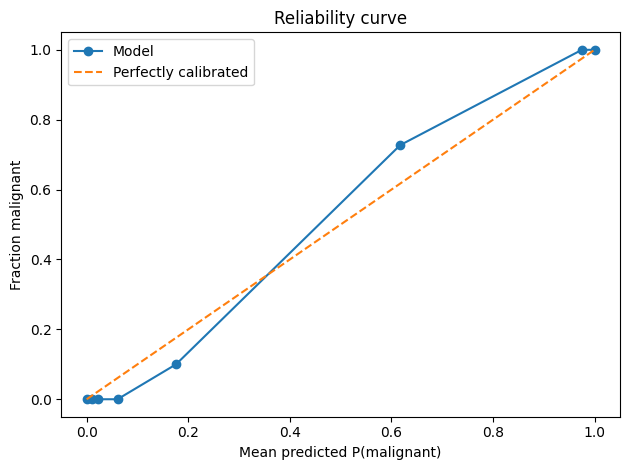

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve

# Treat "malignant" (0) as the positive class
classes = list(model_bc.classes_)
pos_label = 0
pos_idx = classes.index(pos_label)

def p_malignant(df_like: pd.DataFrame) -> np.ndarray:
    """Return P(y=malignant|x) from the trained model."""
    return model_bc.predict_proba(df_like)[:, pos_idx]

# Test-set probabilities & default 0.50 threshold
p_pos_test = p_malignant(X_test)
y_pred_05  = np.where(p_pos_test >= 0.5, 0, 1)

print("=== Report @ threshold 0.50 (positive = malignant) ===")
print(classification_report(y_test, y_pred_05, target_names=["malignant(0)","benign(1)"]))

auc = roc_auc_score((y_test==0).astype(int), p_pos_test)
brier = brier_score_loss((y_test==0).astype(int), p_pos_test)
print(f"ROC AUC (malignant): {auc:.4f}")
print(f"Brier score: {brier:.4f}")

cm = confusion_matrix(y_test, y_pred_05, labels=[0,1])
cm_df = pd.DataFrame(cm, index=["True:mal","True:ben"], columns=["Pred:mal","Pred:ben"])
print("\nConfusion matrix @0.50:\n", cm_df)

# Reliability curve
prob_true, prob_pred = calibration_curve((y_test==0).astype(int), p_pos_test, n_bins=10, strategy='quantile')
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1], [0,1], '--', label='Perfectly calibrated')
plt.xlabel('Mean predicted P(malignant)')
plt.ylabel('Fraction malignant')
plt.title('Reliability curve')
plt.legend()
plt.tight_layout()


At the default 0.50 threshold, the confusion matrix shows **3 false negatives** (malignant -> benign) and **1 false positive**—the FNs are the key safety risk in screening. Discrimination is excellent (**AUC = 0.995**), so the issue isn’t class separability but the **decision policy**. Calibration looks reasonable (**Brier = 0.027**, reliability curve near diagonal), which points to risk coming less from probability error and more from an **unsafe threshold** given **FN ≫ FP**.

Because missing cancer is far costlier than a precautionary biopsy, the next step keeps the model fixed and **re-optimizes the decision threshold** using **Cost(t) = C_FN·FN(t) + C_FP·FP(t)** with **C_FN = 10** and **C_FP = 1**. Sweeping thresholds yields an optimal **t\***, compares **FN/FP at 0.50 vs. t\*** (via confusion matrices), and plots **Cost vs. Threshold**. This checks whether current policy allows **avoidable false negatives** and sets up the upcoming **XAI** analysis of Patient X (and a 0.50-threshold FN) to probe the local rationale.


**Cost-aware thresholding (FN >> FP)**

Best threshold t* = 0.14  (FN=0, FP=9, Cost=9.0)  with C_FN=10.0, C_FP=1.0

Confusion @ 0.50:
           Pred:mal  Pred:ben
True:mal        40         3
True:ben         1        70

Confusion @ t*:
           Pred:mal  Pred:ben
True:mal        43         0
True:ben         9        62

FN@0.50=3  →  FN@t*=0   |   FP@0.50=1  →  FP@t*=9


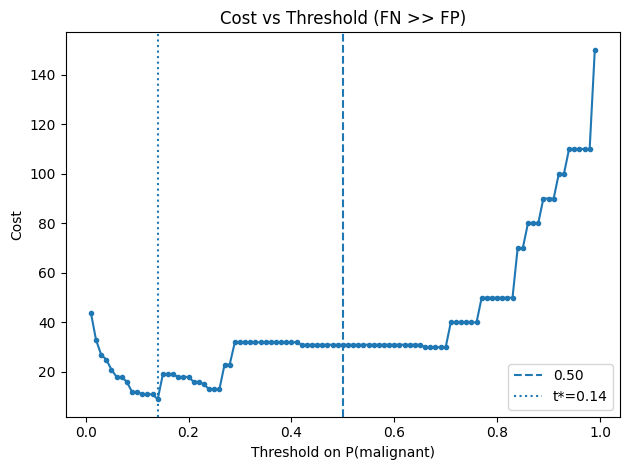

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Treat malignant as positive
y_true_bin = (y_test == 0).astype(int).values

# Clinical costs: Assumption make FN much more expensive than FP
C_FN, C_FP = 10.0, 1.0

ths = np.linspace(0.01, 0.99, 99)
costs, FNs, FPs = [], [], []

for t in ths:
    pred_bin = (p_pos_test >= t).astype(int)
    FN = int(((y_true_bin == 1) & (pred_bin == 0)).sum())
    FP = int(((y_true_bin == 0) & (pred_bin == 1)).sum())
    costs.append(C_FN*FN + C_FP*FP)
    FNs.append(FN); FPs.append(FP)

best_i = int(np.argmin(costs))
best_t = float(ths[best_i])

print(f"Best threshold t* = {best_t:.2f}  (FN={FNs[best_i]}, FP={FPs[best_i]}, Cost={costs[best_i]:.1f})  with C_FN={C_FN}, C_FP={C_FP}")

# Compare 0.50 vs t*
y_pred_05    = np.where(p_pos_test >= 0.50, 0, 1)
y_pred_tstar = np.where(p_pos_test >= best_t, 0, 1)

cm_05 = confusion_matrix(y_test, y_pred_05,    labels=[0,1])
cm_t  = confusion_matrix(y_test, y_pred_tstar, labels=[0,1])

print("\nConfusion @ 0.50:\n", pd.DataFrame(cm_05, index=['True:mal','True:ben'], columns=['Pred:mal','Pred:ben']))
print("\nConfusion @ t*:\n",  pd.DataFrame(cm_t,  index=['True:mal','True:ben'], columns=['Pred:mal','Pred:ben']))

print(f"\nFN@0.50={cm_05[0,1]}  →  FN@t*={cm_t[0,1]}   |   FP@0.50={cm_05[1,0]}  →  FP@t*={cm_t[1,0]}")

# cost curve
plt.figure()
plt.plot(ths, costs, marker='.')
plt.axvline(0.50, ls='--', label='0.50'); plt.axvline(best_t, ls=':', label=f't*={best_t:.2f}')
plt.xlabel('Threshold on P(malignant)'); plt.ylabel('Cost'); plt.title('Cost vs Threshold (FN >> FP)')
plt.legend(); plt.tight_layout()


The best threshold is t* = 0.14. This removes all false negatives (3->0) but raises false positives from 1->9. Since missing a malignant case (FN) is much costlier than a false alarm the overall cost drops a lot—from 31->9 (about 71% lower). This shows the default 0.50 threshold wasn’t aligned with clinical priorities where FN ≫ FP.  

The cost curve also confirms the issue isn’t model discrimination but the decision policy. To dig deeper into why unsafe calls happen at 0.50, the next step is to look at a high-confidence false negative (malignant predicted benign) and compare it with Patient X using SHAP and LIME for local explanation.


In [5]:
# Pick a high-confidence false negative at 0.50 and summarize Patient X

# Predictions on the test set
p_mal_test = p_malignant(X_test)
y_pred_05  = np.where(p_mal_test >= 0.50, 0, 1)

# Diagnostics frame
diag = X_test.copy()
diag["y_true"]    = y_test.values
diag["p_mal"]     = p_mal_test
diag["pred@0.50"] = y_pred_05

# False negatives: malignant (0) predicted benign (1)
fn_df = diag[(diag["y_true"] == 0) & (diag["pred@0.50"] == 1)].copy()

if len(fn_df):
    # High-confidence FN = smallest P(malignant)
    focus_fn = fn_df.sort_values("p_mal", ascending=True).head(1)
    fn_idx   = focus_fn.index[0]
    focus_fn_x = X_test.loc[[fn_idx]]
    print(f"Focus FN index: {fn_idx}")
    print(f"P(malignant) = {float(focus_fn['p_mal'].iloc[0]):.4f} | True=malignant(0) | Pred=benign(1) @0.50")
    display(focus_fn_x)
else:
    print("No false negatives at 0.50; selecting highest-confidence false positive as fallback.")
    fp_df = diag[(diag["y_true"] == 1) & (diag["pred@0.50"] == 0)].copy()
    focus_fn = fp_df.sort_values("p_mal", ascending=False).head(1)
    fn_idx   = focus_fn.index[0]
    focus_fn_x = X_test.loc[[fn_idx]]
    print(f"Fallback FP index: {fn_idx}")
    print(f"P(malignant) = {float(focus_fn['p_mal'].iloc[0]):.4f} | True=benign(1) | Pred=malignant(0) @0.50")
    display(focus_fn_x)

p_mal_px = float(p_malignant(focus_instance_bc)[0])
pred_px  = 0 if p_mal_px >= 0.50 else 1
print(f"\nPatient X → P(malignant) = {p_mal_px:.4f} | Pred@0.50 = {'malignant(0)' if pred_px==0 else 'benign(1)'}")


Focus FN index: 73
P(malignant) = 0.1500 | True=malignant(0) | Pred=benign(1) @0.50


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
73,13.8,15.79,90.43,584.1,0.1007,0.128,0.07789,0.05069,0.1662,0.06566,...,16.57,20.86,110.3,812.4,0.1411,0.3542,0.2779,0.1383,0.2589,0.103



Patient X → P(malignant) = 0.1500 | Pred@0.50 = benign(1)


At test index 73, the model made a high-confidence false negative: P(malignant)=0.15 but predicted benign at 0.50. This is exactly the kind of risky error we worry about confidence was high enough to skip a biopsy, yet the ground truth was malignant. As previously , it shows the default policy allows avoidable FN harm.  

To understand why this happened, we now apply local explainability.

SHAP will show which features pushed the prediction toward malignant for both Patient X and this FN case, with a small population summary for context.

We can compare these results against LIME later.  


**SHAP for Patient Focusing False Negative and Global Importance**

=== SHAP: Patient X ===


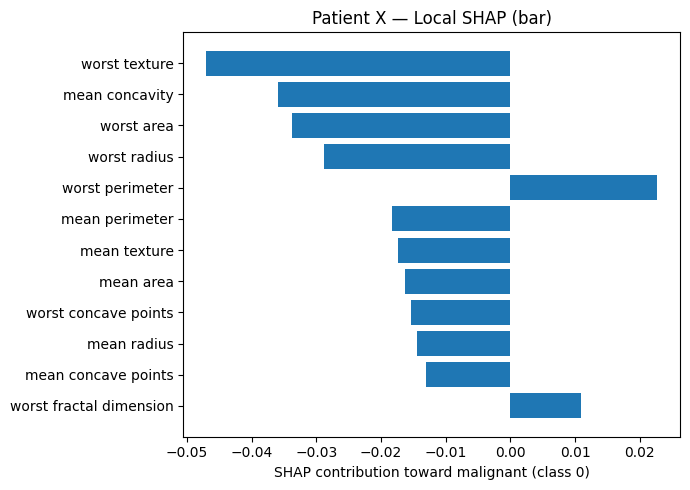


Top local contributors for Patient X — Local SHAP (bar) (toward malignant):
   1. worst texture                ↓  SHAP=-0.0471   value=20.8600
   2. mean concavity               ↓  SHAP=-0.0359   value=0.0779
   3. worst area                   ↓  SHAP=-0.0338   value=812.4000
   4. worst radius                 ↓  SHAP=-0.0288   value=16.5700
   5. worst perimeter              ↑  SHAP=+0.0227   value=110.3000
   6. mean perimeter               ↓  SHAP=-0.0183   value=90.4300
   7. mean texture                 ↓  SHAP=-0.0174   value=15.7900
   8. mean area                    ↓  SHAP=-0.0163   value=584.1000
   9. worst concave points         ↓  SHAP=-0.0154   value=0.1383
  10. mean radius                  ↓  SHAP=-0.0144   value=13.8000
  11. mean concave points          ↓  SHAP=-0.0130   value=0.0507
  12. worst fractal dimension      ↑  SHAP=+0.0109   value=0.1030

Predicted P(malignant) = 0.1500

=== SHAP: Focus False Negative ===


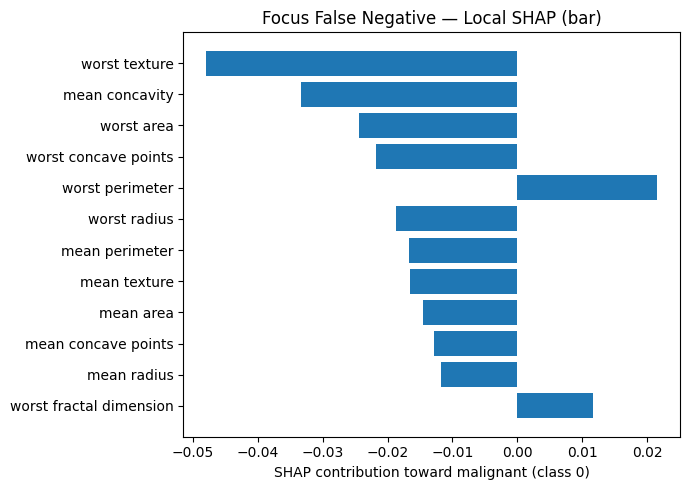


Top local contributors for Focus False Negative — Local SHAP (bar) (toward malignant):
   1. worst texture                ↓  SHAP=-0.0480   value=20.8600
   2. mean concavity               ↓  SHAP=-0.0333   value=0.0779
   3. worst area                   ↓  SHAP=-0.0244   value=812.4000
   4. worst concave points         ↓  SHAP=-0.0218   value=0.1383
   5. worst perimeter              ↑  SHAP=+0.0216   value=110.3000
   6. worst radius                 ↓  SHAP=-0.0187   value=16.5700
   7. mean perimeter               ↓  SHAP=-0.0167   value=90.4300
   8. mean texture                 ↓  SHAP=-0.0165   value=15.7900
   9. mean area                    ↓  SHAP=-0.0146   value=584.1000
  10. mean concave points          ↓  SHAP=-0.0128   value=0.0507
  11. mean radius                  ↓  SHAP=-0.0117   value=13.8000
  12. worst fractal dimension      ↑  SHAP=+0.0117   value=0.1030

Predicted P(malignant) = 0.1500


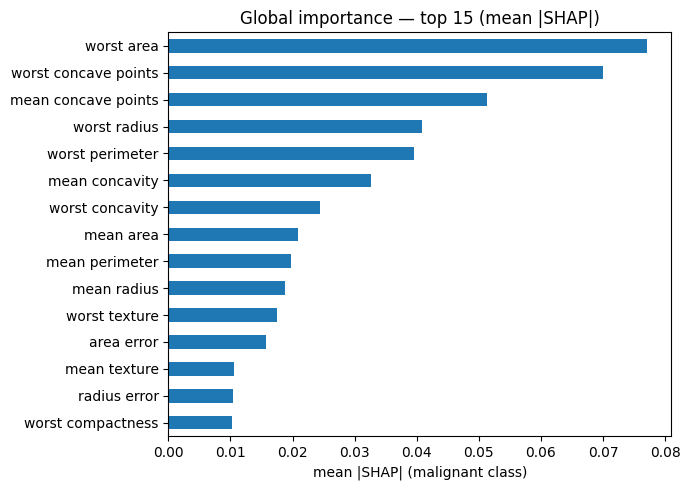


Top global drivers (mean |SHAP|, malignant class):
worst area              0.077109
worst concave points    0.069948
mean concave points     0.051295
worst radius            0.040896
worst perimeter         0.039555
mean concavity          0.032576
worst concavity         0.024394
mean area               0.020833
mean perimeter          0.019804
mean radius             0.018845
dtype: float64


In [6]:
import shap

#Error handling for SHAP Vector
def _to_1x_row(df_row_like: pd.DataFrame, columns) -> pd.DataFrame:
    if isinstance(df_row_like, pd.DataFrame):
        return df_row_like[columns]
    return pd.DataFrame([df_row_like], columns=columns)

def shap_vector_for_instance(explainer, X_row: pd.DataFrame, class_index: int = 0) -> np.ndarray:
    """
    Returns a 1D array (n_features,) of SHAP values for the given row and class.
    Handles SHAP outputs: list of arrays, (n_samples, n_features, n_classes), (n_features, n_classes), etc.
    """
    vals = explainer.shap_values(X_row)
    arr = np.asarray(vals, dtype=object)

    if isinstance(vals, list):
        v = np.asarray(vals[class_index])
        return np.asarray(v[0, :]).ravel()

    arr = np.asarray(vals)
    if arr.ndim == 3:

        if arr.shape[0] == 1 and arr.shape[2] >= class_index+1:
            return arr[0, :, class_index].ravel()

        if arr.shape[0] >= class_index+1 and arr.shape[1] == 1:
            return arr[class_index, 0, :].ravel()
    if arr.ndim == 2:

        if arr.shape[0] == 1 and arr.shape[1] == X_row.shape[1]:
            return arr[0, :].ravel()

        if arr.shape[0] == X_row.shape[1] and arr.shape[1] >= class_index+1:
            return arr[:, class_index].ravel()

    raise ValueError(f"Unexpected SHAP shape for single row: {arr.shape}")

def shap_matrix_for_class(explainer, X_data: pd.DataFrame, class_index: int = 0) -> np.ndarray:
    vals = explainer.shap_values(X_data)
    if isinstance(vals, list):
        return np.asarray(vals[class_index])
    arr = np.asarray(vals)
    if arr.ndim == 3:

        if arr.shape[2] >= class_index+1 and arr.shape[1] == X_data.shape[1]:
            return arr[:, :, class_index]

        if arr.shape[0] >= class_index+1 and arr.shape[2] == X_data.shape[1]:
            return arr[class_index, :, :]
    if arr.ndim == 2 and arr.shape == (len(X_data), X_data.shape[1]):
        return arr
    raise ValueError(f"Unexpected SHAP array shape for dataset: {arr.shape}")

def plot_local_shap_bar(sv_vec: np.ndarray, X_row: pd.DataFrame, title: str, top_k: int = 12):
    feats = X_row.columns

    order = np.argsort(np.abs(sv_vec))[::-1][:top_k]
    vals = sv_vec[order]
    names = feats[order]

    plt.figure(figsize=(7, 5))
    y = np.arange(len(order))
    plt.barh(y, vals)
    plt.yticks(y, names)
    plt.gca().invert_yaxis()
    plt.xlabel('SHAP contribution toward malignant (class 0)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print(f"\nTop local contributors for {title} (toward malignant):")
    for i, idx in enumerate(order):
        sign = "↑" if sv_vec[idx] > 0 else "↓"
        print(f"  {i+1:2d}. {feats[idx]:<28s} {sign}  SHAP={sv_vec[idx]:+.4f}   value={X_row.iloc[0, idx]:.4f}")

explainer = shap.TreeExplainer(model_bc)

print("=== SHAP: Patient X ===")
px = _to_1x_row(focus_instance_bc, X_train.columns)
sv_px = shap_vector_for_instance(explainer, px, class_index=0)
plot_local_shap_bar(sv_px, px, title="Patient X — Local SHAP (bar)")

p_px = float(p_malignant(px)[0])
print(f"\nPredicted P(malignant) = {p_px:.4f}")

# Focus False Negative
if 'focus_fn_x' in globals():
    print("\n=== SHAP: Focus False Negative ===")
    fnx = _to_1x_row(focus_fn_x, X_train.columns)
    sv_fn = shap_vector_for_instance(explainer, fnx, class_index=0)
    plot_local_shap_bar(sv_fn, fnx, title="Focus False Negative — Local SHAP (bar)")
    p_fn = float(p_malignant(fnx)[0])
    print(f"\nPredicted P(malignant) = {p_fn:.4f}")
else:
    print("\n(No focus false negative available — skipping FN SHAP.)")

# Global importance:
sv_train = shap_matrix_for_class(explainer, X_train, class_index=0)   # (n_samples, n_features)
mean_abs = np.abs(sv_train).mean(axis=0)
global_importance = pd.Series(mean_abs, index=X_train.columns).sort_values(ascending=True)

top = global_importance.tail(15)
plt.figure(figsize=(7, 5))
top.plot(kind='barh')
plt.xlabel('mean |SHAP| (malignant class)')
plt.title('Global importance — top 15 (mean |SHAP|)')
plt.tight_layout()
plt.show()

print("\nTop global drivers (mean |SHAP|, malignant class):")
print(global_importance.sort_values(ascending=False).head(10))


For Patient X and the focus FN (P(malignant)=0.15), SHAP shows benign-pushing effects from worst texture, mean concavity, worst area, and worst radius.

Malignant signals from worst perimeter and worst fractal dimension were weaker. Globally, worst area and worst concave points are strong malignancy drivers, but in this case they lowered the malignant score.

This mismatch suggests the model underweighted key clinical indicators (size/shape irregularity) and leaned too much on texture/concavity—explaining the unsafe benign call.  

Next, LIME will be applied to the same cases to cross-check SHAP. By running LIME with different random seeds, we can test how stable the results are. If LIME and SHAP agree, the explanation is more trustworthy. If they disagree or vary a lot, it raises doubts about the model’s reliability.  



In [7]:
!pip -q install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**LIME local explanations and stability**


=== LIME: Patient X ===


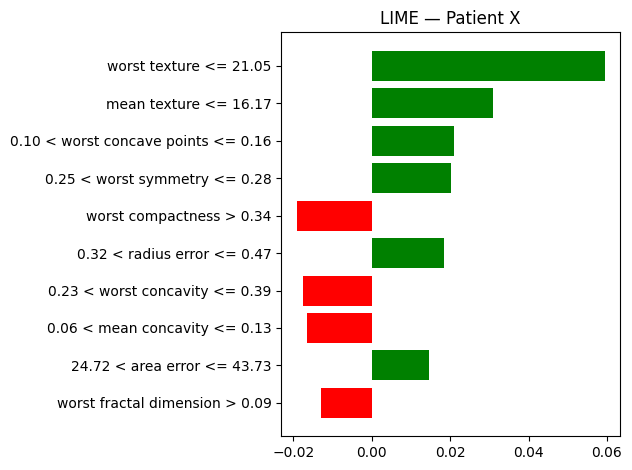


Top LIME weights — Patient X:
  worst texture <= 21.05                   weight=+0.0594
  mean texture <= 16.17                    weight=+0.0309
  0.10 < worst concave points <= 0.16      weight=+0.0209
  0.25 < worst symmetry <= 0.28            weight=+0.0201
  worst compactness > 0.34                 weight=-0.0192
  0.32 < radius error <= 0.47              weight=+0.0185
  0.23 < worst concavity <= 0.39           weight=-0.0177
  0.06 < mean concavity <= 0.13            weight=-0.0164
  24.72 < area error <= 43.73              weight=+0.0146
  worst fractal dimension > 0.09           weight=-0.0130

LIME stability — Patient X (rows = conditions, cols = seeds):


,0,1,2,3,4
worst texture <= 21.05,0.063571,0.065624,0.056768,0.053959,0.064088
mean texture <= 16.17,0.021454,0.026201,0.032930,0.033581,0.032754
worst compactness > 0.34,-0.019424,-0.015118,-0.022022,-0.021128,-0.010917
0.25 < worst symmetry <= 0.28,0.014502,0.012525,0.000000,0.000000,0.000000
0.06 < mean concavity <= 0.13,-0.012904,0.000000,0.000000,-0.021994,-0.015776
0.23 < worst concavity <= 0.39,-0.012234,0.000000,-0.012972,-0.012344,-0.012412
0.10 < worst concave points <= 0.16,0.011887,0.017600,0.000000,0.019277,0.000000
24.72 < area error <= 43.73,0.010482,0.017601,0.012598,0.014491,0.000000
0.03 < mean concave points <= 0.07,-0.010367,-0.013836,-0.016848,0.000000,0.000000
worst fractal dimension > 0.09,-0.010294,0.000000,0.000000,0.000000,-0.015375



Top-k LIME stability — Patient X


,mean_weight,std_weight,mean_abs_weight,nonzero_seeds,sign_consistency
worst texture <= 21.05,0.060802,0.005119,0.060802,5,1.0
mean texture <= 16.17,0.029384,0.005352,0.029384,5,1.0
worst compactness > 0.34,-0.017722,0.004639,0.017722,5,1.0
24.72 < area error <= 43.73,0.011034,0.006700,0.011034,4,1.0
0.06 < mean concavity <= 0.13,-0.010135,0.009818,0.010135,3,1.0
0.23 < worst concavity <= 0.39,-0.009993,0.005593,0.009993,4,1.0
0.10 < worst concave points <= 0.16,0.009753,0.009315,0.009753,3,1.0
0.03 < mean concave points <= 0.07,-0.008210,0.007838,0.008210,3,1.0
0.02 < symmetry error <= 0.02,0.008124,0.007865,0.008124,3,1.0
97.67 < worst perimeter <= 124.65,-0.007011,0.010078,0.007011,2,1.0


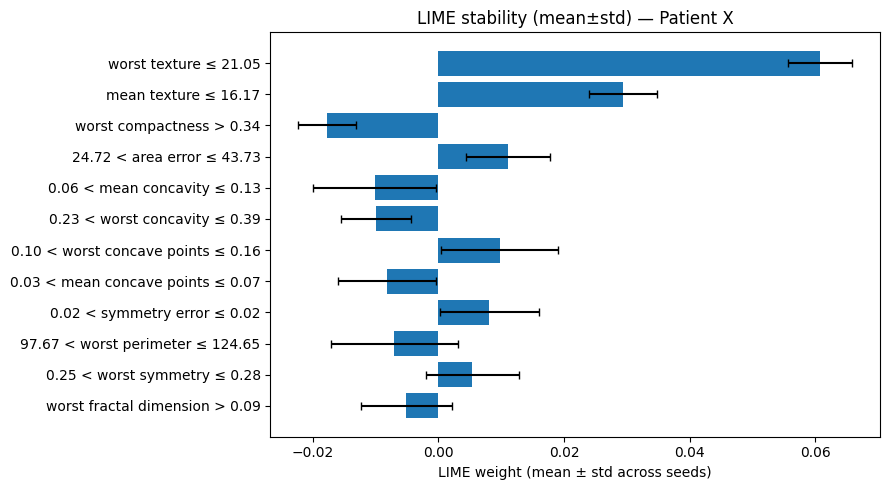


=== LIME: Focus False Negative ===


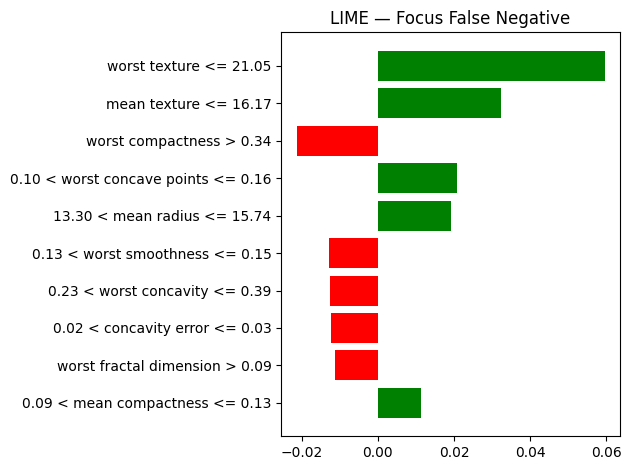


Top LIME weights — Focus False Negative:
  worst texture <= 21.05                   weight=+0.0595
  mean texture <= 16.17                    weight=+0.0323
  worst compactness > 0.34                 weight=-0.0213
  0.10 < worst concave points <= 0.16      weight=+0.0208
  13.30 < mean radius <= 15.74             weight=+0.0192
  0.13 < worst smoothness <= 0.15          weight=-0.0128
  0.23 < worst concavity <= 0.39           weight=-0.0126
  0.02 < concavity error <= 0.03           weight=-0.0123
  worst fractal dimension > 0.09           weight=-0.0114
  0.09 < mean compactness <= 0.13          weight=+0.0113

LIME stability — Focus False Negative (rows = conditions, cols = seeds):


,0,1,2,3,4
worst texture <= 21.05,0.064009,0.064307,0.056909,0.054710,0.064543
mean texture <= 16.17,0.021594,0.026911,0.032555,0.033808,0.032354
worst compactness > 0.34,-0.019009,-0.015798,-0.022510,-0.021841,0.000000
18.17 < area error <= 24.72,0.018818,0.016526,0.012305,0.012785,0.018189
0.25 < worst symmetry <= 0.28,0.013995,0.013213,0.000000,0.000000,0.000000
0.23 < radius error <= 0.32,0.013831,0.015511,0.010430,0.000000,0.014838
0.23 < worst concavity <= 0.39,-0.012535,0.000000,-0.013322,-0.012216,-0.012664
0.06 < mean concavity <= 0.13,-0.012441,0.000000,0.000000,-0.022136,-0.016565
0.10 < worst concave points <= 0.16,0.011524,0.017195,0.000000,0.019692,0.000000
1.65 < perimeter error <= 2.29,0.010330,0.000000,0.000000,0.000000,0.000000



Top-k LIME stability — Focus False Negative


,mean_weight,std_weight,mean_abs_weight,nonzero_seeds,sign_consistency
worst texture <= 21.05,0.060896,0.004711,0.060896,5,1.0
mean texture <= 16.17,0.029444,0.005129,0.029444,5,1.0
worst compactness > 0.34,-0.015832,0.009239,0.015832,4,1.0
18.17 < area error <= 24.72,0.015725,0.003026,0.015725,5,1.0
0.23 < radius error <= 0.32,0.010922,0.006411,0.010922,4,1.0
0.06 < mean concavity <= 0.13,-0.010228,0.009951,0.010228,3,1.0
0.23 < worst concavity <= 0.39,-0.010148,0.005687,0.010148,4,1.0
0.10 < worst concave points <= 0.16,0.009682,0.009321,0.009682,3,1.0
97.67 < worst perimeter <= 124.65,-0.006856,0.009658,0.006856,2,1.0
0.03 < mean concave points <= 0.07,-0.006221,0.008622,0.006221,2,1.0


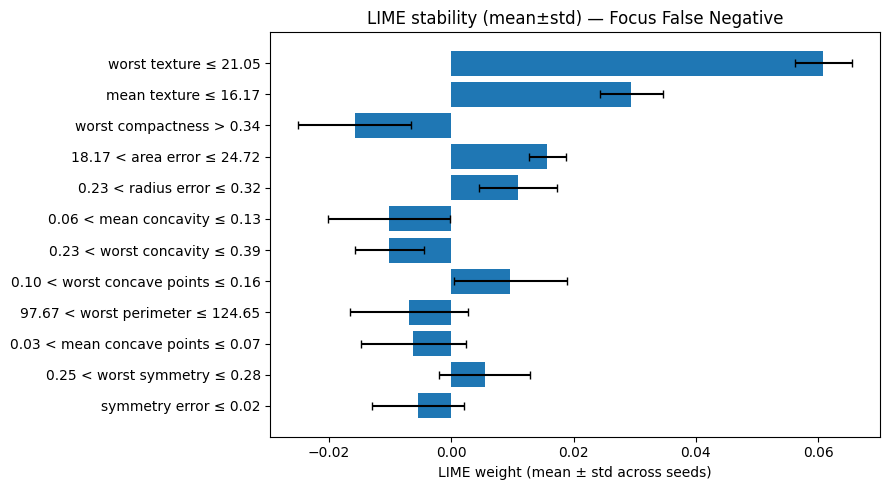

In [8]:
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_tabular import LimeTabularExplainer

import textwrap
from IPython.display import display

feature_names = X_train.columns.tolist()
class_names   = ["malignant(0)", "benign(1)"]

def predict_proba_original(x_array: np.ndarray) -> np.ndarray:
    df_like = pd.DataFrame(x_array, columns=feature_names)
    return model_bc.predict_proba(df_like)

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    random_state=42
)

def lime_explain_and_print(title: str, x_row_df: pd.DataFrame, num_features: int = 10):
    """Render LIME figure and print weights for one instance."""
    exp = lime_explainer.explain_instance(
        data_row=x_row_df.values[0],
        predict_fn=predict_proba_original,
        num_features=min(num_features, x_row_df.shape[1])
    )
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME — {title}"); plt.tight_layout(); plt.show()
    print(f"\nTop LIME weights — {title}:")
    for feat, w in exp.as_list():
        print(f"  {feat:<40s} weight={w:+.4f}")
    return exp

def lime_weights_for_seed(seed: int, x_row_df: pd.DataFrame, num_features: int = 10) -> dict:
    ex = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        discretize_continuous=True,
        random_state=seed
    )
    e = ex.explain_instance(
        data_row=x_row_df.values[0],
        predict_fn=predict_proba_original,
        num_features=min(num_features, x_row_df.shape[1])
    )
    return dict(e.as_list())

def summarize_lime_stability(df: pd.DataFrame, top_k: int = 12) -> pd.DataFrame:
    """Aggregate weights across seeds: mean, std, mean|weight|, count nonzero, sign consistency."""
    if df is None or df.empty:
        return pd.DataFrame()
    mean = df.mean(axis=1)
    std  = df.std(axis=1)
    mean_abs = df.abs().mean(axis=1)
    nonzero = (df != 0).sum(axis=1)

    def frac_consistent(row):
        m = np.sign(mean[row.name])
        signs = np.sign(row.replace(0, np.nan).dropna())
        return (signs == m).mean() if len(signs) else 0.0

    sign_consistency = df.apply(frac_consistent, axis=1).fillna(0.0)

    out = pd.DataFrame({
        "mean_weight": mean,
        "std_weight": std,
        "mean_abs_weight": mean_abs,
        "nonzero_seeds": nonzero.astype(int),
        "sign_consistency": sign_consistency
    }).sort_values("mean_abs_weight", ascending=False).head(top_k)
    return out

def shorten(label: str, width: int = 38) -> str:
    s = (label.replace(" <= ", " ≤ ")
              .replace(" >= ", " ≥ ")
              .replace(" < ",  " < ")
              .replace(" > ",  " > "))
    return "\n".join(textwrap.wrap(s, width))

def barh_with_error(stats: pd.DataFrame, title: str):
    if stats is None or stats.empty:
        print(f"{title}: no data")
        return
    labels = [shorten(s) for s in stats.index.tolist()]
    y = np.arange(len(stats))
    plt.figure(figsize=(9, 5))
    plt.barh(y, stats["mean_weight"], xerr=stats["std_weight"], capsize=3)
    plt.yticks(y, labels); plt.gca().invert_yaxis()
    plt.xlabel("LIME weight (mean ± std across seeds)")
    plt.title(title); plt.tight_layout(); plt.show()


px = focus_instance_bc[feature_names]
print("=== LIME: Patient X ===")
lime_px = lime_explain_and_print("Patient X", px)

seeds = [0,1,2,3,4]
weights_px = [lime_weights_for_seed(s, px) for s in seeds]
lime_px_df = pd.DataFrame(weights_px).T.fillna(0.0)
print("\nLIME stability — Patient X (rows = conditions, cols = seeds):"); display(lime_px_df)

stats_px = summarize_lime_stability(lime_px_df, top_k=12)
print("\nTop-k LIME stability — Patient X"); display(stats_px)
barh_with_error(stats_px, "LIME stability (mean±std) — Patient X")


# LIME on Focus False Negative
if 'focus_fn_x' in globals():
    fnx = focus_fn_x[feature_names]
    print("\n=== LIME: Focus False Negative ===")
    lime_fn = lime_explain_and_print("Focus False Negative", fnx)

    weights_fn = [lime_weights_for_seed(s, fnx) for s in seeds]
    lime_fn_df = pd.DataFrame(weights_fn).T.fillna(0.0)
    print("\nLIME stability — Focus False Negative (rows = conditions, cols = seeds):"); display(lime_fn_df)

    stats_fn = summarize_lime_stability(lime_fn_df, top_k=12)
    print("\nTop-k LIME stability — Focus False Negative"); display(stats_fn)
    barh_with_error(stats_fn, "LIME stability (mean±std) — Focus False Negative")
else:
    print("\n(No focus false negative available — skipping FN LIME.)")


**SHAP** shows the prediction being pushed **away from malignant** by **low-texture** and **concavity** signals (e.g., *worst texture*, *mean concavity*), while classic **size/shape** cues (e.g., *worst area*, *perimeter*, *concave points*) have smaller local impact. **LIME** matches this: rules like `worst texture ≤ 21.05` and `mean texture ≤ 16.17`  carry the largest **benign-pushing** weights for both Patient X and the focus FN.

Stability checks indicate this isn’t noise. The top LIME rules show **sign_consistency = 1.0**, **low std** (~0.005–0.01), and appear across most seeds, so the model is **consistently** prioritizing texture thresholds locally.

In the **global** context, mean-|SHAP| ranks **size/irregularity features** (worst area, concave points, radius, perimeter) as top malignancy drivers, yet **locally** these are **down-weighted** while texture dominates. This **global–local mismatch** explains **high-confidence benign** errors: malignant cases with relatively smooth texture get under-referred.

Policy-wise, with **FN ≫ FP**, the default **0.50** threshold is unsafe. A cost-aware sweep (C_FN=10, C_FP=1) picks **t* ≈ 0.14**, which changes **FN: 3 -> 0** and **FP: 1 -> 9**—a safer trade-off for oncology. Patient X’s **P(malignant) ≈ 0.15** falls in this zone; under **t*** the case would be referred.

**Key takeaways:**

* SHAP + LIME agree: **low texture** rules **suppress malignant risk** locally.
* Globally strong malignancy cues (size/shape irregularity) are **underweighted locally**, explaining the miss.
* The decision policy is **misaligned** with harm; a cost-aware **t*** removes test-set FNs at acceptable FP cost.


**Summary tables**

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss
from IPython.display import display
import shap

# Malignant probabilities on test
mal_idx = list(model_bc.classes_).index(0)
try:
    p_pos_test
except NameError:
    p_pos_test = model_bc.predict_proba(X_test)[:, mal_idx]

y_true_mal = (y_test == 0).astype(int).values

# Discrimination & calibration
auc   = roc_auc_score(y_true_mal, p_pos_test)
brier = brier_score_loss(y_true_mal, p_pos_test)
metrics_df = pd.DataFrame(
    {"Metric": ["AUC (malignant)", "Brier score"], "Value": [auc, brier]}
)
display(metrics_df.round(4))

# Threshold comparison: 0.50 vs cost-aware t*
C_FN, C_FP = 10.0, 1.0
ths = np.linspace(0.01, 0.99, 99)
costs, FNs, FPs = [], [], []
for t in ths:
    pred_bin = (p_pos_test >= t).astype(int)
    FN = int(((y_true_mal==1) & (pred_bin==0)).sum())
    FP = int(((y_true_mal==0) & (pred_bin==1)).sum())
    FNs.append(FN); FPs.append(FP); costs.append(C_FN*FN + C_FP*FP)
best_t = float(ths[int(np.argmin(costs))])

def cm_counts_at(t):
    y_pred = np.where(p_pos_test >= t, 0, 1)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    TN, FP = cm[1,1], cm[1,0]
    FN, TP = cm[0,1], cm[0,0]
    return TP, FP, FN, TN, C_FN*FN + C_FP*FP

tp50, fp50, fn50, tn50, cost50 = cm_counts_at(0.50)
tpt,  fpt,  fnt,  tnt,  costt  = cm_counts_at(best_t)

thresholds_df = pd.DataFrame(
    {
        "Threshold": ["0.50", f"{best_t:.2f} (t*)"],
        "TP": [tp50, tpt],
        "FP": [fp50, fpt],
        "FN": [fn50, fnt],
        "TN": [tn50, tnt],
        "Cost (C_FN=10, C_FP=1)": [cost50, costt],
    }
)
display(thresholds_df)

def pred_label_at(p, t):
    return "malignant(0)" if p >= t else "benign(1)"

p_px = float(model_bc.predict_proba(focus_instance_bc)[:, mal_idx][0])
px_df = pd.DataFrame({
    "Case": ["Patient X"],
    "P(malignant)": [p_px],
    "Pred @ 0.50": [pred_label_at(p_px, 0.50)],
    f"Pred @ t*={best_t:.2f}": [pred_label_at(p_px, best_t)]
})

rows = [px_df]
if 'focus_fn_x' in globals():
    p_fn = float(model_bc.predict_proba(focus_fn_x)[:, mal_idx][0])
    fn_df = pd.DataFrame({
        "Case": ["Focus FN"],
        "P(malignant)": [p_fn],
        "Pred @ 0.50": [pred_label_at(p_fn, 0.50)],
        f"Pred @ t*={best_t:.2f}": [pred_label_at(p_fn, best_t)]
    })
    rows.append(fn_df)
px_fn_df = pd.concat(rows, ignore_index=True)
display(px_fn_df.assign(**{"P(malignant)": px_fn_df["P(malignant)"].round(3)}))

# SHAP top features
explainer = shap.TreeExplainer(model_bc)

def shap_vec_one(x_row_df, class_index=0):
    vals = explainer.shap_values(x_row_df)
    if isinstance(vals, list):
        return np.asarray(vals[class_index])[0]
    arr = np.asarray(vals)
    if arr.ndim == 3 and arr.shape[0] == 1:
        return arr[0, :, class_index]
    if arr.ndim == 3 and arr.shape[1] == 1:
        return arr[class_index, 0, :]
    if arr.ndim == 2 and arr.shape[0] == 1:
        return arr[0]
    if arr.ndim == 2 and arr.shape[0] == x_row_df.shape[1]:
        return arr[:, class_index]
    raise ValueError(f"Unexpected SHAP shape: {arr.shape}")

def top_pos_neg_df(sv, cols, k=5):
    cols = np.array(cols)
    idx_pos = np.argsort(sv)[::-1][:k]
    idx_neg = np.argsort(-sv)[::-1][:k]
    df_pos = pd.DataFrame({"Feature": cols[idx_pos], "SHAP (↑ malignant)": sv[idx_pos]})
    df_neg = pd.DataFrame({"Feature": cols[idx_neg], "SHAP (↓ malignant / benign)": sv[idx_neg]})
    return df_pos.reset_index(drop=True), df_neg.reset_index(drop=True)


sv_px = shap_vec_one(focus_instance_bc)
pos_px_df, neg_px_df = top_pos_neg_df(sv_px, focus_instance_bc.columns, k=5)
print("Patient X — top local SHAP (↑ malignant)"); display(pos_px_df)
print("Patient X — top local SHAP (↓ malignant / benign)"); display(neg_px_df)

if 'focus_fn_x' in globals():
    sv_fn = shap_vec_one(focus_fn_x)
    pos_fn_df, neg_fn_df = top_pos_neg_df(sv_fn, focus_fn_x.columns, k=5)
    print("Focus FN — top local SHAP (↑ malignant)"); display(pos_fn_df)
    print("Focus FN — top local SHAP (↓ malignant / benign)"); display(neg_px_df)


,Metric,Value
0,AUC (malignant),0.9953
1,Brier score,0.0269


,Threshold,TP,FP,FN,TN,"Cost (C_FN=10, C_FP=1)"
0,0.50,40,1,3,70,31.0
1,0.14 (t*),43,9,0,62,9.0


,Case,P(malignant),Pred @ 0.50,Pred @ t*=0.14
0,Patient X,0.15,benign(1),malignant(0)
1,Focus FN,0.15,benign(1),malignant(0)


Patient X — top local SHAP (↑ malignant)


,Feature,SHAP (↑ malignant)
0,worst perimeter,0.022736
1,worst fractal dimension,0.010869
2,area error,0.008712
3,radius error,0.005174
4,worst concavity,0.003085


Patient X — top local SHAP (↓ malignant / benign)


,Feature,SHAP (↓ malignant / benign)
0,worst texture,-0.047076
1,mean concavity,-0.035873
2,worst area,-0.033790
3,worst radius,-0.028783
4,mean perimeter,-0.018262


Focus FN — top local SHAP (↑ malignant)


,Feature,SHAP (↑ malignant)
0,worst perimeter,0.021600
1,worst fractal dimension,0.011725
2,worst smoothness,0.005687
3,symmetry error,0.004627
4,worst concavity,0.003395


Focus FN — top local SHAP (↓ malignant / benign)


,Feature,SHAP (↓ malignant / benign)
0,worst texture,-0.047076
1,mean concavity,-0.035873
2,worst area,-0.033790
3,worst radius,-0.028783
4,mean perimeter,-0.018262


## Discussion & Conclusion

The model is technically strong but the **decision policy** is unsafe for screening. It separates classes well (**AUC ≈ 0.995**) and is reasonably calibrated (**Brier ≈ 0.027**), yet with the default **0.50** threshold it still produces **3 false negatives** (and 1 false positive) on the test set.

In oncology, **FN ≫ FP**—missing a malignancy is far worse than sending a few extra patients to biopsy—so a 0.50 cutoff bakes in the wrong trade-off from the start.

Using a cost-aware sweep (C_FN=10, C_FP=1), the best decision cutoff is t* ≈ 0.14. At the default 0.50 threshold the test confusion is TP=40, FN=3, FP=1, TN=70; at t* it becomes TP=43, FN=0, FP=9, TN=62. In plain terms: false negatives drop to zero (safer) at the cost of more false positives. Since Patient X has P(malignant)=0.15, the case is benign at 0.50 but would be referred (malignant) at t*.

Local explanations show *why* the default policy let this slip through. **SHAP** for Patient X (and the matched false negative) highlights **low texture** and **low concavity** features—especially *worst texture* and *mean concavity*—as the strongest **negative** contributions that pull the prediction **away from malignant**.

Smaller **positive** pushes (toward malignant) come from *worst perimeter*, *worst fractal dimension*, and small error terms. **LIME** tells the same story with simple rules: `worst texture ≤ 21.05` and `mean texture ≤ 16.17` are the top **benign-pushing** conditions. The stability checks matter here: those rules have **sign_consistency ≈ 1.0** and **low standard deviation**, so this isn’t a flaky surrogate—it’s a **systematic texture-first rationale**.

From the **population** view, global mean-|SHAP| ranks **size/shape irregularity** (e.g., *worst area*, *(worst/mean) concave points*, *worst radius*, *worst perimeter*) as the strongest malignancy drivers overall.

But locally, for Patient X, those same features are **down-weighted**, while texture dominates. That **global–local mismatch** is exactly how you get **high-confidence benign** errors: malignant cases that present with relatively smooth texture get under-referred even when size/shape indicators are not reassuring.

Clinically, the effect is simple: lowering the threshold from 0.50 to t* ≈ 0.14 drops the false-negative rate from ~7% (3/43 malignant cases), while adding about 8 extra biopsies (FP 1 -> 9) out of 114 patients. Given FN ≫ FP in screening, that trade-off is appropriate. In short, the model is fine; it’s the decision policy/threshold that’s misaligned with the clinical goal.

## Prosecution Final Verdict

>The benign call for **Patient X** is **not clinically defensible** in a screening setting where **FN ≫ FP**. Despite strong overall performance, the system’s **0.50 threshold** **encodes the wrong risk trade-off**, and its **texture-first** local rationale (from **SHAP/LIME**) downplays critical **size/shape** cues such as worst area, perimeter, and concave points that are globally most indicative of malignancy. A **cost-aware cutoff** (**t*** from the analysis) aligns decisions with clinical harm by prioritizing missed-cancer avoidance and would have referred Patient X. To make the decision process defensible going forward, the policy should switch to this lower threshold, add an **alert zone** for borderline probabilities, and include a brief **feature/objective audit** so size/shape indicators carry appropriate weight. In short, the model’s scoring ability is sound; the **decision policy and local feature emphasis** are misaligned with clinical priorities—and fixing those would likely have prevented this miss.
